# Modelling
This notebook is responsible for the models that will try to predict the different target variables. This notebook implements 2 different types of models, namely a regularised regression model and a Random Forest model. Both models are implemented twice with the same feature set but two different target variables, namely standarised mean SCL and corrected HRV SDNN. 

#### Requirements
If one wants to run this notebook, make sure that you have run the `5-ak-window-processing` notebook. This notebook is responsible for adding the gender and age features to the sampled windows.

In [1]:
import pandas as pd
import numpy as np
import os
import random
from sklearn.svm import SVR
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

After loading in the required modules, we store the working directory in a variable called `project_dir`. We then store the folder where the data files are located in a variable called `data_dir`. We store directory that stores the processed DataFrames aswell as the files themselves in different variables.

In [2]:
project_dir = os.getcwd().split('\\')[:-1]
project_dir = '\\'.join(project_dir) # Get the project dir
data_dir = project_dir + '\\data' # Get the data dir
processed_dir = data_dir + '\\processed' # Get the processed subdir
processed_files = [file for file in os.listdir(processed_dir) if file.endswith('hdf') and file.startswith('processed_')] # Get all the processed DataFrames

### Target, Features, Window size & Step size
Next we define the window and step size of the samples. It is possible to change the window and step sizes, by changing the values in the next cell. We also store the features and targets in two different variables, and subset the DataFrame to only contain the the relevant columns.

In [3]:
WINDOW = 180 # Choose the window length
STEP = 1 # Choose the step size
df = pd.read_hdf(f'{processed_dir}\\processed_window_{WINDOW}_step_{int(WINDOW * STEP)}.hdf') # Load in the correct DataFrame
features = ['mean_AU01', 'mean_change_AU01', 'mean_AU02', 'mean_change_AU02', 'mean_AU04',
           'mean_change_AU04', 'mean_AU05', 'mean_change_AU05', 'mean_AU06',
           'mean_change_AU06', 'mean_AU07', 'mean_change_AU07', 'mean_AU09',
           'mean_change_AU09', 'mean_AU10', 'mean_change_AU10', 'mean_AU12',
           'mean_change_AU12', 'mean_AU14', 'mean_change_AU14', 'mean_AU15',
           'mean_change_AU15', 'mean_AU17', 'mean_change_AU17', 'mean_AU20',
           'mean_change_AU20', 'mean_AU23', 'mean_change_AU23', 'mean_AU25',
           'mean_change_AU25', 'mean_AU26', 'mean_change_AU26', 'mean_AU45',
           'mean_change_AU45', 'std_AU01', 'std_AU02', 'std_AU04', 'std_AU05',
           'std_AU06', 'std_AU07', 'std_AU09', 'std_AU10', 'std_AU12', 'std_AU14',
           'std_AU15', 'std_AU17', 'std_AU20', 'std_AU23', 'std_AU25', 'std_AU26',
           'std_AU45', 'mean_Arousal', 'mean_Happy', 'mean_Sad', 'mean_Angry',
           'mean_Scared', 'std_pose_Tx', 'std_pose_Ty', 'std_pose_Tz',
           'std_pose_Rx', 'std_pose_Ry', 'std_pose_Rz', 'compound_Motion',
           'mean_PD', 'std_PD', 'max_PD', 'blink_rate'] # List all the features
targets = ['standardised_mean_scl', 'HRV_SDNN_corrected'] # List all the target variables
cols = features + targets + ['pp'] # Create a list of all the relevant cols, besides features and targets add pp id 
data = df[cols] # Subset the DataFrame to only the relevant cols.

### Train and Test set
Below we split the windows in a train and test set. First, we randomly select 10 participants, whose windows will be the test set. The windows of the remaining participants will act as the train set. We copy the train and test DataFrames to two different variables, one for each model. Due to the natural of the linear model we will need to perform a transformation on the features. 

In [4]:
testset_pp = random.sample(list(df.pp.unique()), 10) # Select a set of windows from 10 unique pps as test set

## Split the DataFrame based on the pps selected above
## Create a test and train df for the two different models, since we need to perform transformations on the LR model
LR_test_df = df[df.pp.isin(testset_pp)].copy()
LR_train_df = df[~df.pp.isin(testset_pp)].copy()

### Visualisation
The cell below implements a function that will handle the visualisation of the model predictions against the actual values. It will create a simple plot, and store this in the correct folder.

In [5]:
def create_plot(plot_data, target, model):
    """Creates a simple scatter plot, based on the """
    fig, ax = plt.subplots()
    
    vmin = plot_data[['true_y', 'predicted_y']].min().min()
    vmax = plot_data[['true_y', 'predicted_y']].max().max()
    
    ax.scatter(x = plot_data['true_y'], y = plot_data['predicted_y'])
    ax.set_title(f'{model}: Prediction of {target}')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    ax.plot((vmin, vmax),(vmin, vmax), 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    plt.savefig(f'{project_dir}\\reports\\figures\\{model}_{target}.jpg')

In [6]:
print(len(features))

67


### Models
The cell below implements the cross validation and testing phase of the modeling process. For each of two model types and for each of 2 target variables, it executes the training phase by running a 10-fold subject crossvalidation to determine the best hyperparameters, after which it evaluates the performance of the best model found in the crossvalidation against the samples in the test set. These results are then stored in a DataFrame and saved to the `data\processed`. We also run the visualisation function during each iteration, resulting in 4 different plots, stored in the `reports\figures` directory.

Finding best SVM model for: standardised_mean_scl
Fitting 10 folds for each of 160 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1048 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Best parameters set found on validation set:
{'C': 0.1, 'epsilon': 0.001, 'gamma': 'scale', 'kernel': 'rbf'}
Best score found on validation set:
-0.011662984291047373

R Squared found on test data: 
0.002771991146399033
RMSE found on test data: 
0.2004011344039638

Finding best SVM model for: HRV_SDNN_corrected
Fitting 10 folds for each of 160 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1389 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    1.8s finished


Best parameters set found on validation set:
{'C': 0.1, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Best score found on validation set:
-0.2466923373505022

R Squared found on test data: 
0.049881115353604955
RMSE found on test data: 
0.5386353218503569



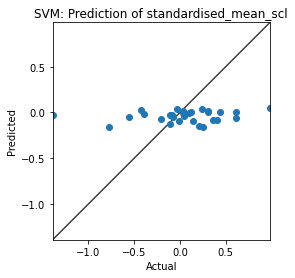

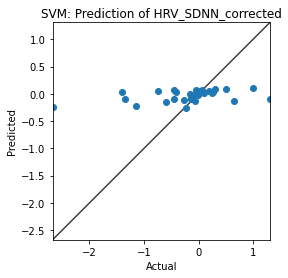

In [7]:
results = [] # Create a list to store the results in
model='SVM'
for target in targets: # For each target variable
    print(f'Finding best {model} model for: {target}')

    tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1000],
                         'kernel':['rbf'],
                         'gamma':['scale', 'auto'],
                         'epsilon': [0.001, 0.01, 0.1, 10, 1000]}, 
                        {'C': [0.001, 0.01, 0.1, 1000],
                         'kernel':['poly'],
                         'gamma':['scale', 'auto'],
                         'epsilon': [0.001, 0.01, 0.1, 10, 1000], 
                         'degree': [2, 3, 4]}] # Set the hyperparams to tune during CV
    regr = SVR() # Instantiate the model, with the correct hyperparams

    train_df = LR_train_df.copy() # Set the train DataFrame
    test_df = LR_test_df.copy() # Set the test DataFrame

    scaler = StandardScaler() # Instantiate the object responsible for standardisation
    train_df[features + targets] = scaler.fit_transform(train_df[features + targets]) # Fit the object to the windows in the train set and then transform the columns in the train set
    test_df[features + targets] = scaler.transform(test_df[features + targets]) # Uses the fitted object scaler to also transform the columns in the test set


    LPSO = GroupKFold(n_splits=10) # Instantiate the CV split object, which is responsible for splitting the training set in 10 groups of equal amount of participants
    split_iter = LPSO.split(train_df[features], train_df[target], train_df.pp) # Split the train DataFrame based on the pp id, which makes sure that a pp only occurs in one split

    RMSE = make_scorer(mean_squared_error, greater_is_better=False, squared=False) # Instantiate a scorer object, which is responsible for computing the RootMeanSquareError (RMSE)

    regression = GridSearchCV(regr, tuned_parameters, verbose=1, n_jobs=-1, cv=split_iter) # Instantiate a GridSearch CV object with the current model, tuneable params and CV split object

    regression.fit(train_df[features], train_df[target]) # Fit the GridSearch CV object with the data samples present in the dataset

    print("Best parameters set found on validation set:")
    print(regression.best_params_) # The best hyperparams that were found using the 10-fold CV Grid Search
    print("Best score found on validation set:")
    print(regression.best_score_) # The best scores that were found, using the model with the above mentioned params, trained on the entire dataset 

    pred_y = regression.best_estimator_.predict(X=test_df[features]) # Let the best model predict the values of the samples in the testset
    true_y = test_df[target] # Set the true values of the samples in the test set

    print(f'\nR Squared found on test data: \n{regression.best_estimator_.score(X=test_df[features], y=test_df[target])}') # Compute the R Squared of the model on the test set
    print(f'RMSE found on test data: \n{mean_squared_error(y_true=test_df[target], y_pred=regression.best_estimator_.predict(X=test_df[features]))}\n') # Compute the RMSE of the model found on the test set

    result = {} # Create a dict to store the results in 
    result['model'] = model # Set the model
    result['target'] = target # Set the target
    result['R_squared'] = regression.best_estimator_.score(X=test_df[features], y=test_df[target]) # Set the R Squared
    result['RMSE'] = mean_squared_error(y_true=test_df[target], y_pred=regression.best_estimator_.predict(X=test_df[features])) # set the RMSE
    results.append(result) # Add this result to the list of results

    plot_data = pd.DataFrame({'true_y': true_y, 'predicted_y': pred_y}) # Create a DataFrame for the visualisation
    create_plot(plot_data, target, model) # Plot the predicted values against the actual values
        
df = pd.DataFrame.from_records(results) # Store the final results in a single DataFrame
df.to_hdf(f'{processed_dir}\\SVM_RESULTS.hdf', key='results') # Save this DataFrame in the correct directory

In [8]:
df # Show the Final Results

,model,target,R_squared,RMSE
0,SVM,standardised_mean_scl,0.002772,0.200401
1,SVM,HRV_SDNN_corrected,0.049881,0.538635
